# Analysis


## input data


In [71]:
from auth import sp

def get_all_user_playlists():
    playlists = []
    results = sp.current_user_playlists(limit=50)
    playlists.extend(results['items'])

    while results['next']:
        results = sp.next(results)
        playlists.extend(results['items'])

    return playlists

# Function to handle fetching audio analysis
def get_audio_analysis(track_id):
    try:
        analysis = sp.audio_analysis(track_id)
        
        # Flatten each section with list comprehension and take the first element if available
        bars_info = {f'bar_{k}': v for k, v in analysis['bars'][0].items()} if analysis['bars'] else {}
        beats_info = {f'beat_{k}': v for k, v in analysis['beats'][0].items()} if analysis['beats'] else {}
        sections_info = {f'section_{k}': v for k, v in analysis['sections'][0].items()} if analysis['sections'] else {}
        segments_info = {f'segment_{k}': v for k, v in analysis['segments'][0].items()} if analysis['segments'] else {}
        tatums_info = {f'tatum_{k}': v for k, v in analysis['tatums'][0].items()} if analysis['tatums'] else {}

        # Combine all the flattened sections into a single dictionary
        audio_analysis_info = {**bars_info, **beats_info, **sections_info, **segments_info, **tatums_info}
        
        return audio_analysis_info
    except Exception as e:
        print(f"Error fetching audio analysis for track ID {track_id}: {e}")
        return {}
    
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [72]:
import pandas as pd
from utils import fetch_all_playlist_tracks

# Get user's playlists
playlists = get_all_user_playlists()
total_playlists = len(playlists)

try:
    existing_tracks_df = pd.read_csv('rated.csv')
    existing_track_ids = existing_tracks_df['id'].tolist()
except FileNotFoundError:
    existing_tracks_df = pd.DataFrame()
    existing_track_ids = []
except:
    print('Error reading existing tracks from CSV.')
    existing_tracks_df = pd.DataFrame()
    existing_track_ids = []
    
# Get the tracks from the playlists in the "Rated" folder
tracks = []
for i, playlist in enumerate(playlists):
    if playlist['name'] in ["0.5", "1.0", "1.5", "2.0", "2.5", "3.0", "3.5", "4.0", "4.5", "5.0"]:
        playlist_id = playlist['id']
        playlist_tracks = fetch_all_playlist_tracks(playlist_id)
        track_ids = [item['track']['id'] for item in playlist_tracks]
        
        # Get audio features for each track
        num_tracks_to_fetch = 100  # Maximum number of tracks to fetch at once
        for j in range(0, len(track_ids), num_tracks_to_fetch):
            audio_features_list = sp.audio_features(track_ids[j:j+num_tracks_to_fetch])
            
            artist_ids = [track['track']['artists'][0]['id'] for track in playlist_tracks[j:j+num_tracks_to_fetch]]

            # Initialize a list to hold all the genres
            genres_list = []

        # Fetch artist genres in chunks of 50
        for artist_chunk in chunks(artist_ids, 50):
            artists_info = sp.artists(artist_chunk)
            genres_list.extend([artist['genres'] for artist in artists_info['artists']])
        
        
        for track, audio_features, genres in zip(playlist_tracks[j:j+num_tracks_to_fetch], audio_features_list, genres_list):
            track = track['track']
            track_id = track['id']
            
            audio_analysis = get_audio_analysis(track_id)
            
            # Merge track, its audio features, analysis, and genres
            track.update(audio_features)
            track.update(audio_analysis)
            track['genres'] = genres
            
            # Add rating to track
            track['rating'] = float(playlist['name'])  # Convert the playlist name to float and use it as the rating
            tracks.append(track)
    
    print(f'\rProcessed {i+1} of 10 playlists...', end='')

df = pd.DataFrame(tracks)

# Add new columns for artist ID and genres
df['artist_id'] = df['artists'].apply(lambda x: x[0]['id'])
df['genres'] = df.apply(lambda x: ', '.join(x['genres']), axis=1)

# Select columns to keep
columns_to_keep = [
    # "album",
    "id",
    "artist_id",
    "genres",
    "duration_ms",
    "explicit",
    "popularity",
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "time_signature",
    "rating",
]
df = df[columns_to_keep]

# save tracks to csv
print('\nSaving tracks to CSV...')

# try then wait for user input if can't in order for the user to close the file if it's open
try:
    df.to_csv('rated.csv', index=False)
except PermissionError:
    input('Please close the file "rated.csv" then press enter to continue...')
    df.to_csv('rated.csv', index=False)

print(f'Done. Total number of rated songs: {len(tracks)}')


Error reading existing tracks from CSV.
Processed 17 of 10 playlists...Fetching tracks from '1.0' by Bill


Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=50DU0QuX7gVMVGQj7bxUST,22AbXxQbMdVqEz7xJjhccG,1Vp4St7JcXaUoJcIahtf3L,3aGibUHhQyBsyumYHylw0K,7y8X0Z04gJCKtfrnSAMywJ:
 Max Retries, reason: too many 429 error responses

## output data


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
try:
    tracks_df = pd.read_csv('rated.csv')
except FileNotFoundError:
    print("Error: 'rated.csv' not found.")
    exit()

# Preprocess data
tracks_df = tracks_df.sample(frac=1).reset_index(drop=True)  # Shuffle the data
tracks_df.dropna(inplace=True)  # Drop rows with missing values

# Split the categorical data into separate rows
genres_df = tracks_df['genres'].str.get_dummies(sep=', ')
artists_df = tracks_df['artist_id'].str.get_dummies()

# Drop the original 'genres' and 'artist_id' column and concatenate the one-hot encoded dataframe
tracks_df = pd.concat([tracks_df.drop('genres', axis=1), genres_df], axis=1)
tracks_df = pd.concat([tracks_df.drop('artist_id', axis=1), artists_df], axis=1)

# Normalize numeric columns
numeric_columns = ['duration_ms', 'popularity', 'danceability', 'energy', 'loudness', 'tempo', 'time_signature', 'key']  # Specify your numeric columns
tracks_df[numeric_columns] = (tracks_df[numeric_columns] - tracks_df[numeric_columns].min()) / (tracks_df[numeric_columns].max() - tracks_df[numeric_columns].min())

# Convert boolean columns to int
boolean_columns = [column for column in tracks_df.columns if tracks_df[column].dtype == 'bool']
tracks_df[boolean_columns] = tracks_df[boolean_columns].astype(int)

# Define your target variable
target_column = 'rating'  # Replace this with the column that represents the rating of a track

# Split data into features (X) and target variable (y)
X = tracks_df.drop(target_column, axis=1)
y = tracks_df[target_column]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()


,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,acoustic blues,adult standards,aesthetic rap,afro r&b,afrobeat,afrobeats,afrofuturism,album rock,alt z,alternative dance,alternative hip hop,alternative metal,alternative pop rock,alternative r&b,alternative rock,ambient,american folk revival,ann arbor indie,appalachian folk,arkansas country,art pop,art punk,art rock,atl hip hop,atl trap,australian alternative rock,australian dance,australian hip hop,australian indie folk,australian pop,australian rock,avant-garde metal,bahamian folk,barbadian pop,baroque,baroque pop,baton rouge rap,beatlesque,bedroom pop,bedroom r&b,belgian pop,big band,big room,blues,blues rock,blues-rock guitar,bolero cubano,boston hardcore,boston rock,boy band,brill building pop,british folk,british invasion,british singer-songwriter,british soul,britpop,brooklyn drill,brostep,bubblegrunge,bubblegum pop,cabaret,cali rap,calypso,canadian contemporary r&b,canadian hip hop,canadian old school hip hop,canadian pop,canadian post-rock,canadian trap,candy pop,cante flamenco,canzone napoletana,chamber pop,chanson,chaotic hardcore,chicago blues,chicago bop,chicago drill,chicago indie,chicago rap,chicago soul,chill abstract hip hop,chill drill,chill pop,christmas instrumental,classic country pop,classic girl group,classic j-rock,classic rock,classic soul,classic uk pop,classical,classical era,classify,collage pop,colombian pop,comic,compositional ambient,conscious hip hop,contemporary country,contemporary r&b,contemporary vocal jazz,country,country blues,country gospel,country rock,coverchill,dance pop,dance rock,danish alternative rock,danish pop,danish rock,dark jazz,dark r&b,dark trap,deep new americana,delta blues,detroit hip hop,dfw rap,dirty south rap,disco,dixieland,doo-wop,double drumming,dream pop,drill,drill italiana,drumless hip hop,dutch pop,early music,early romantic era,east coast hip hop,easy listening,ectofolk,edm,edmonton indie,electric blues,electro,electro house,electronica,electropop,elephant 6,emo,emo rap,escape room,ethereal wave,etherpop,eurodance,europop,experimental hip hop,experimental pop,experimental rock,experimental vocal,filter house,finnish edm,flamenco,florida drill,florida rap,folk,folk rock,folk-pop,french indie pop,french indietronica,french synthpop,funk,funk metal,funk rock,g funk,g-house,gangster rap,garage rock,gauze pop,gen z singer-songwriter,german baroque,german drill,german hip hop,german romanticism,girl group,glam metal,glam rock,grunge,hard rock,hardcore hip hop,harlem renaissance,harmonica blues,heartland rock,hip hop,hip house,hip pop,hollywood,house,icelandic experimental,icelandic pop,icelandic singer-songwriter,indie anthem-folk,indie folk,indie game soundtrack,indie pop,indie poptimism,indie quebecois,indie rock,indie soul,indietronica,indonesian viral pop,industrial hip hop,instrumental hip hop,instrumental post-rock,instrumental rock,instrumental worship,irish rock,irish singer-songwriter,italian tenor,j-rock,japanese classical,japanese contemporary classical,japanese dream pop,japanese soundtrack,jazz,jazz blues,jazz funk,jazz pop,jazz rock,jazz trombone,jazz trumpet,jump blues,kentucky hip hop,korean city pop,latin pop,latin viral pop,latinx alternative,lgbtq+ hip hop,lilith,lo-fi,lo-fi indie,lounge,madchester,mathcore,melancholia,mellow gold,melodic drill,melodic rap,memphis blues,memphis hip hop,memphis soul,merseybeat,metalcore,metropopolis,miami bass,miami hip hop,minneapolis sound,modern alternative rock,modern blues,modern indie pop,modern rock,moog,moombahton,motown,movie tunes,musica tradicional cubana,nashville sound,neo mellow,neo soul,neon pop punk,new orleans jazz,new orleans rap,new rave,new romantic,new wave,new wave pop,new york drill,nigerian pop,no wave,noise pop,north carolina hip hop,north east england indie,northern soul,nu metal,nwothm,nyc rap,old school atlanta hip hop,olympia wa indie,orc

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming X and y are your features and target variables as Pandas DataFrames or Series

# Define hyperparameters
n_estimators = 1200
max_depth = 25
min_samples_split = 2
min_samples_leaf = 2

# Initialize the model with the given hyperparameters
rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,  min_samples_leaf=min_samples_leaf, random_state=42)

# Define a K-fold cross validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define scores to collect
scores = {
    'MAE': [],
    'MSE': [],
    'R2': []
}

# Perform the k-fold cross validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Make predictions
    predictions = rf.predict(X_test)
    
    # Compute and append scores
    scores['MAE'].append(mean_absolute_error(y_test, predictions))
    scores['MSE'].append(mean_squared_error(y_test, predictions))
    scores['R2'].append(r2_score(y_test, predictions))

# Calculate the mean and standard deviation for each metric
mean_scores = {metric: np.mean(scores[metric]) for metric in scores}
std_scores = {metric: np.std(scores[metric]) for metric in scores}

# Print the results
for metric in mean_scores:
    print(f"{metric}: Mean={mean_scores[metric]}, STD={std_scores[metric]}")


In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming X and y are your features and target variables as Pandas DataFrames or Series

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 500, 1200],
    'max_depth': [10, 25, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Define a K-fold cross validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X, y)

# Best hyperparameter combination
print("Best hyperparameters:", grid_search.best_params_)

# Best model (retrained on the entire dataset using the best hyperparameters)
best_rf = grid_search.best_estimator_

# Optionally, evaluate the best model's performance
predictions = best_rf.predict(X)  # or use a separate test set if available

# Compute and print scores
print("MAE:", mean_absolute_error(y, predictions))
print("MSE:", mean_squared_error(y, predictions))
print("R2:", r2_score(y, predictions))


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming X and y are your features and target variables as Pandas DataFrames or Series

# Define hyperparameters
n_estimators = 1200
max_depth = 25
min_samples_split = 2
min_samples_leaf = 2

# Initialize the model with the given hyperparameters
rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                             min_samples_split=min_samples_split,  
                             min_samples_leaf=min_samples_leaf, random_state=42)

# Define a K-fold cross validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define scores to collect
scores = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

# Perform the k-fold cross validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    rfc.fit(X_train, y_train)
    
    # Make predictions
    predictions = rfc.predict(X_test)
    
    # Compute and append scores
    scores['Accuracy'].append(accuracy_score(y_test, predictions))
    scores['Precision'].append(precision_score(y_test, predictions, average='macro'))
    scores['Recall'].append(recall_score(y_test, predictions, average='macro'))
    scores['F1'].append(f1_score(y_test, predictions, average='macro'))

# Calculate the mean and standard deviation for each metric
mean_scores = {metric: np.mean(scores[metric]) for metric in scores}
std_scores = {metric: np.std(scores[metric]) for metric in scores}

# Print the results
for metric in mean_scores:
    print(f"{metric}: Mean={mean_scores[metric]}, STD={std_scores[metric]}")


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

### analyse feature importance


In [74]:
feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

importance_df[:20]


,Feature,Importance
8,speechiness,0.117612
9,acousticness,0.099525
2,popularity,0.096883
3,danceability,0.076488
0,duration_ms,0.074291
4,energy,0.073342
6,loudness,0.064825
11,liveness,0.057847
13,tempo,0.056933
12,valence,0.049008


## visualisations


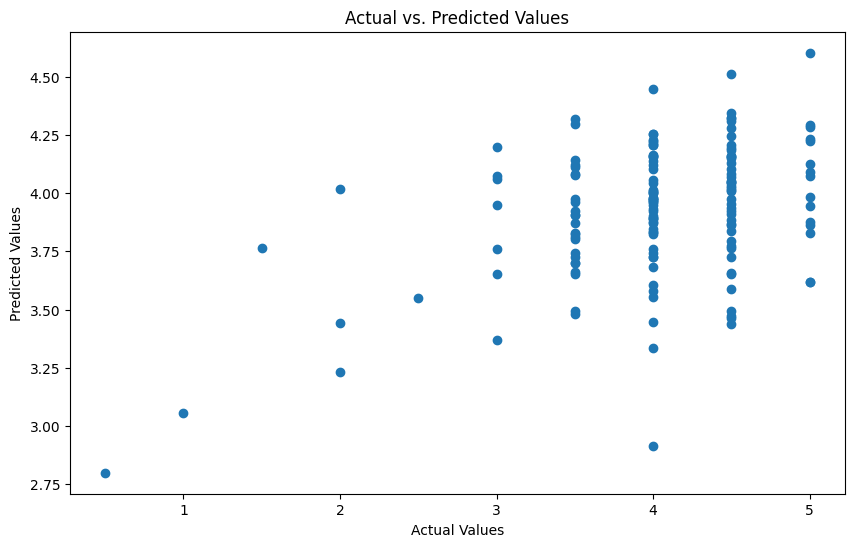

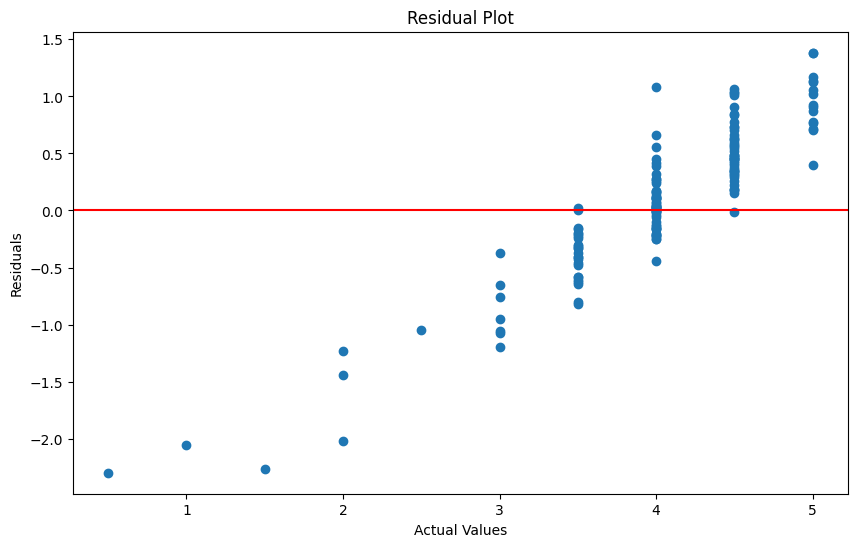

In [75]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

# Add y=x line
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.show()

# Residual plot
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Give Recommendations to Users Based on Their Preferences


## load unrated songs


In [ ]:
sources_ids = [
    "37i9dQZEVXcToZ9oox3nki",
    "37i9dQZF1DWZdLqpoFOt65",
    "37i9dQZEVXbn0l6flXloCt",
    "37i9dQZF1DWW1yuCSjnKtM",
    "22mm5J4DcucnRDLv0BAvti",
    "1h419AHuvIuFXjUjndFC25",
    "0gqrnk12Q8OExuCeKyBRCq",
    "3wXgQJZudZsz7RGyPMTQGa",
    "12TqMgaZKMw6RF39JK6eeF"
]
# discover weekly
# for you.
# release radar
# !!!
# discover weekly (cash)
# discovered weekly (trending.)
# BEST SONGS OF ALL TIME
# best tracks from the top albums of all time - RYM (RateYourMusic)
# 1001 songs you must hear before you die (2017 edition)

In [ ]:
import os
import pandas as pd
from utils import fetch_all_playlist_tracks
from auth import sp

# Load rated songs if exists and ensure it has the correct structure
if os.path.exists('rated.csv') and os.path.getsize('rated.csv') > 0:
    rated_songs = pd.read_csv('rated.csv')
    # Ensure 'id' column exists, add it if not
    if 'id' not in rated_songs.columns:
        rated_songs['id'] = pd.Series(dtype='str')
else:
    rated_songs = pd.DataFrame(columns=['id'])

# Initialize a set to keep track of unique track IDs, handle empty DataFrame case
unique_track_ids = set(rated_songs['id'].tolist()) if not rated_songs.empty else set()

# Load unrated songs if exists
unrated_songs = pd.read_csv('unrated.csv') if os.path.exists('unrated.csv') and os.path.getsize('unrated.csv') > 0 else pd.DataFrame()

tracks = []

for playlist_id in sources_ids:
    playlist_tracks = fetch_all_playlist_tracks(playlist_id)
    track_ids = [t['track']['id'] for t in playlist_tracks if t['track'] is not None and 'id' in t['track'] and t['track']['id'] not in unique_track_ids]

    # Update the unique_track_ids set
    unique_track_ids.update(track_ids)

    # Get audio features for each track
    for j in range(0, len(track_ids), 100):
        try:
            audio_features_list = sp.audio_features(track_ids[j:j+100])
        except Exception as e:
            print(f"Error fetching audio features: {e}")
            continue
        
        for track, audio_features in zip(playlist_tracks[j:j+100], audio_features_list):
            track = track['track']
            if track is None or 'id' not in track or audio_features is None:
                continue
            
            tracks.append({
                'id': track['id'],
                'name': track['name'],
                'artist': track['artists'][0]['name'] if track['artists'] else 'Unknown',
                'album': track['album']['name'] if 'album' in track else 'Unknown',
                'release_date': track['album']['release_date'] if 'album' in track else 'Unknown',
                'duration_ms': track['duration_ms'],
                'popularity': track['popularity'],
                **{k: v for k, v in audio_features.items() if v is not None}
            })

print(f"\nProcessed {len(tracks)} tracks")

# Convert to DataFrame and save to CSV
tracks_df = pd.DataFrame(tracks)
tracks_df.to_csv("unrated.csv", index=False)


Fetching tracks from 'Discover Weekly' by Spotify
Fetching tracks from 'for you.' by Spotify
Fetching tracks from 'Release Radar' by Spotify
Fetching tracks from '!!!' by Spotify
Fetching tracks from 'Discover Weekly' by cash
Error fetching audio features: expected string or bytes-like object, got 'NoneType'
Fetching tracks from 'Discovered Weekly' by trending.
Fetching tracks from 'BEST SONGS OF ALL TIME' by Best Songs Of All Time
Fetching tracks from 'best tracks from the top albums of all time - RYM (RateYourMusic)' by Henrique Oliveira


KeyboardInterrupt: 

## recommend songs


### using ranges of audio features


In [ ]:
import numpy as np

# Define a range of values for each feature
feature_values = {
    'danceability': np.arange(0.0, 1.1, 0.1),
    'energy': np.arange(0.0, 1.1, 0.1),
    'valence': np.arange(0.0, 1.1, 0.1),
}

# Predict ratings for each combination of feature values
from itertools import product

best_rating = -np.inf
best_combination = {}

for combination in product(*feature_values.values()):
    features_dict = dict(zip(feature_values.keys(), combination))
    features_df = pd.DataFrame([features_dict])
    rating_prediction = rf.predict(features_df)[0]
    
    if rating_prediction > best_rating:
        best_rating = rating_prediction
        best_combination = features_dict

print(f"Best combination for high rating: {best_combination}")


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- acousticness
- artists_00FQb4jTyendYWaN8pK0wa
- artists_00tVTdpEhQQw1bqdu8RCx2
- artists_01WDDvvDKa3B0WSiqQKqCb
- artists_027TpXKGwdXP7iwbjUSpV8
- ...


### using list of unrated songs


In [ ]:
import pandas as pd

# Set display options
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', 199)  # or 199

# Load data of unrated songs
unrated_songs = pd.read_csv('unrated.csv')

# Keep a copy of song names, artist, album, and id
song_data = unrated_songs[["name", "artist", "album", "id"]]

# Preprocess data
unrated_songs = unrated_songs.dropna()  # Drop rows with missing values
unrated_songs = pd.get_dummies(unrated_songs.drop(["name", "artist", "album", "id"], axis=1))  # One-hot encode categorical data excluding song data

# Make sure the unrated songs data has the same columns as the training data
missing_cols = set(X_train.columns) - set(unrated_songs.columns)
missing_df = pd.DataFrame(0, index=unrated_songs.index, columns=list(missing_cols))
unrated_songs = pd.concat([unrated_songs, missing_df], axis=1)
unrated_songs = unrated_songs[X_train.columns]

# Predict ratings of unrated songs
predicted_ratings = rf.predict(unrated_songs)

# Add predicted ratings and song data to unrated songs data
unrated_songs['predicted_rating'] = predicted_ratings
unrated_songs = pd.concat([unrated_songs, song_data], axis=1)

# Create Spotify link using the song's ID
unrated_songs['spotify_link'] = 'https://open.spotify.com/track/' + unrated_songs['id']

# Recommend the top 10 songs with the highest predicted ratings
recommended_songs = unrated_songs.nlargest(10, 'predicted_rating')

# Reset index and print recommended songs
recommended_songs = recommended_songs.reset_index(drop=True)

# Display the table
recommended_songs[["name", "artist", "album", "spotify_link", "predicted_rating"]]

,name,artist,album,spotify_link,predicted_rating
0,The Beginning and the End,ISIS,Oceanic (Remastered),https://open.spotify.com/track/3T6hC2yWf0fsUxM7uWXkDn,4.378783
1,Queen Elvis,Robyn Hitchcock,Eye,https://open.spotify.com/track/1ZkYlfoM8PxQsTaCr14yRA,4.376759
2,Hammer Down,Magnolia Electric Co.,Sojourner (Parts 1 & 2),https://open.spotify.com/track/6qzOPSNPZwTkQVLTuzofok,4.376407
3,"Ecailles de lune, Pt. 1",Alcest,Écailles de lune,https://open.spotify.com/track/5xbuJuQsTVheVZvX2AJVIv,4.363975
4,Over The Rainbow,Judy Garland,The Wizard of Oz: Original Motion Picture Soundtrack (Deluxe Edition),https://open.spotify.com/track/3bvJmkcbQXeQ4xhWrf7vkH,4.359309
5,Vitamin C,CAN,Ege Bamyasi (Remastered),https://open.spotify.com/track/1hVRTl4yhWmGW7ImZoO22e,4.355391
6,A Christmas Fucking Miracle,Run The Jewels,Run The Jewels,https://open.spotify.com/track/3pxBEx5tiFRPcihyvkCsP2,4.348144
7,Desperate Man Blues,Daniel Johnston,Hi How Are You,https://open.spotify.com/track/3KlThglLgU5sE86o2SVIVM,4.342214
8,A More Perfect Union,Titus Andronicus,The Monitor,https://open.spotify.com/track/4HXShgD3c3dq65CtAqoqzh,4.339490
9,Psychotic Reaction,Count Five,Psychotic Reaction,https://open.spotify.com/track/55NuNNfuZlf1fFsGAySkTw,4.338848


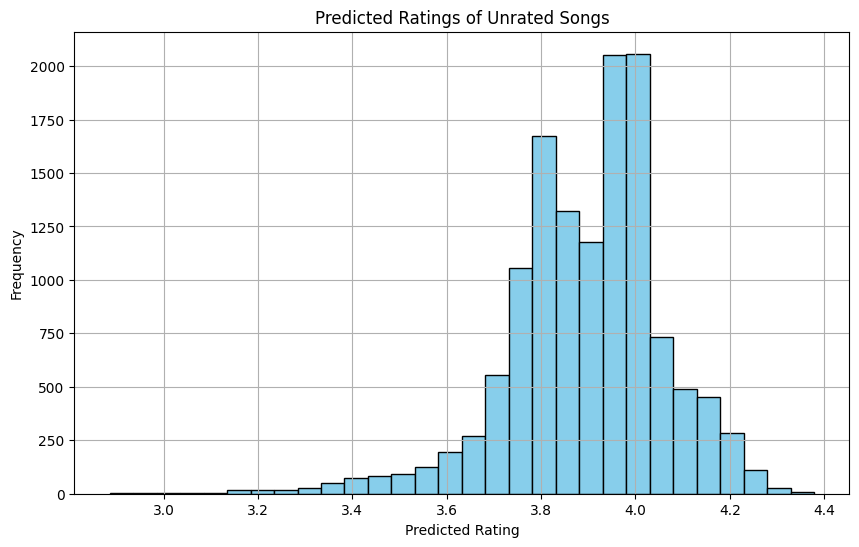

In [ ]:
# Load data of unrated songs
unrated_songs = pd.read_csv('unrated.csv')

# Keep a copy of song names, artist, album, and id
song_data = unrated_songs[["name", "artist", "album", "id"]]

# Preprocess data
unrated_songs = unrated_songs.dropna()  # Drop rows with missing values
unrated_songs = pd.get_dummies(unrated_songs.drop(["name", "artist", "album", "id"], axis=1))  # One-hot encode categorical data excluding song data

# Make sure the unrated songs data has the same columns as the training data
missing_cols = set(X_train.columns) - set(unrated_songs.columns)
missing_df = pd.DataFrame(0, index=unrated_songs.index, columns=list(missing_cols))
unrated_songs = pd.concat([unrated_songs, missing_df], axis=1)
unrated_songs = unrated_songs[X_train.columns]

# Predict ratings of unrated songs
predicted_ratings = rf.predict(unrated_songs)

# Add predicted ratings and song data to unrated songs data
unrated_songs['predicted_rating'] = predicted_ratings
unrated_songs = pd.concat([unrated_songs, song_data], axis=1)

# Plot a graph of the predicted ratings
plt.figure(figsize=(10, 6))
plt.hist(unrated_songs['predicted_rating'], bins=30, color='skyblue', edgecolor='black')
plt.title('Predicted Ratings of Unrated Songs')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()